In [10]:
%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# $v_\text{1kpc}$ vs. $v_\text{max}$

First, imports:

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy import units
from pathlib import Path
import os

import snapshot_obj
import dataset_compute
import curve_fit

import importlib

In [12]:
importlib.reload(snapshot_obj)
importlib.reload(dataset_compute)
importlib.reload(curve_fit)

<module 'curve_fit' from '/home/kassiili/Curvaton_Simulations/analysis/curve_fit.py'>

## Construct data dictionary

Add entries for each simulation, and specify M31 and MW galaxies:

In [13]:
snap_id = 127
sim_ids = ["V1_LR_fix", "V1_LR_curvaton_p082_fix", "V1_LR_curvaton_p084_fix"]
names = ["LCDM", "p082", "p084"]
paths = ["", "/media/kassiili/USBFREE/LG_simulations", 
        "/media/kassiili/USBFREE/LG_simulations"]

# Define M31 and MW in each simulation:
m31 = [(1,0), (1,0), (1,0)]
mw = [(2,0), (1,1), (1,1)]

data = {}
for name, sim_id, sim_path, m31_ns, mw_ns in zip(names, sim_ids, paths, m31, mw):
    data[name] = {"snapshot": snapshot_obj.Snapshot(sim_id, snap_id, name=name,
                                                    sim_path=sim_path),
                  "M31_identifier": m31_ns,
                  "MW_identifier": mw_ns}

Choose how to distinguish between satellite and isolated galaxies:

In [14]:
distinction = "by_r"

Read datasets, split into satellites and isolated galaxies, and add to the data dictionary. Add entries for all subhalos as well as luminous and dark subhalos. We also disregard potential spurious halos with $v_\mathrm{max} = 0$.

In [15]:
for name, sim_data in data.items():
    # Get data:
    snap = sim_data["snapshot"]
    max_point = snap.get_subhalos("Max_Vcirc", "Extended")
    vmax = max_point[:,0] * units.cm.to(units.km)
    v1kpc = snap.get_subhalos("V1kpc", "Extended") * units.cm.to(units.km)
    
    # Split into satellites:
    if distinction == "by_r":
        masks_sat, mask_isol = dataset_compute.split_satellites_by_distance(
            snap, sim_data["M31_identifier"], sim_data["MW_identifier"])
    elif distinction == "by_gn":
        masks_sat, mask_isol = dataset_compute.split_satellites_by_group_number(
            snap, sim_data["M31_identifier"], sim_data["MW_identifier"])
        
    mask_lum, mask_dark = dataset_compute.split_luminous(snap)
    mask_nonzero_vmax = dataset_compute.prune_vmax(snap)

    # Add to dictionary:
    for dataset_name, dataset in zip(["Vmax", "V1kpc"],[vmax, v1kpc]):
        data[name][dataset_name] = \
        {"satellites": 
         {"all": dataset[np.logical_and(
             np.logical_or.reduce(masks_sat), mask_nonzero_vmax
         )],
          "luminous": dataset[np.logical_and.reduce(
             [np.logical_or.reduce(masks_sat), mask_lum, mask_nonzero_vmax]
         )],
          "dark": dataset[np.logical_and.reduce(
              [np.logical_or.reduce(masks_sat), mask_dark, mask_nonzero_vmax]
          )]
         },
         "isolated":
         {"all": dataset[np.logical_and(
             mask_isol, mask_nonzero_vmax
         )],
          "luminous": dataset[np.logical_and.reduce(
             [mask_isol, mask_lum, mask_nonzero_vmax]
         )],
          "dark": dataset[np.logical_and.reduce(
              [mask_isol, mask_dark, mask_nonzero_vmax]
          )]
         }
        }

## Plot all subhalos

In [16]:
# Set some parameters:
x_down = 10; x_up = 100
y_down = 10; y_up = 70

# Set marker styles:
fcolor = ["black", "red", "blue", "green"]
mcolor = ["gray", "pink", "lightblue", "lightgreen"]
marker = ['+', "o", "^", 1]

In [17]:
# Construct saving location:
filename = 'V1kpc_vs_Vmax_all_{}'.format(distinction)
for name in names:
    filename += "_{}".format(name)
filename += ".png"
    
home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures")
filename = os.path.join(path, filename)

# of satellites: 105
# of isolated galaxies: 163
# of satellites: 51
# of isolated galaxies: 82
# of satellites: 11
Could not fit median for: p084
# of isolated galaxies: 73


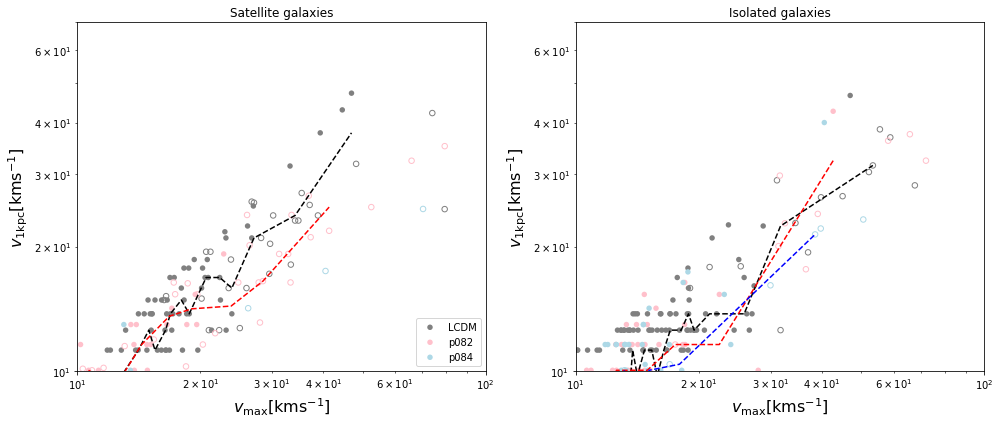

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))
plt.subplots_adjust(wspace=0.3)

# Set axis:
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(x_down, x_up)
    ax.set_ylim(y_down, y_up)
    ax.set_xlabel('$v_{\mathrm{max}} [\mathrm{kms^{-1}}]$', fontsize=16)
    ax.set_ylabel('$v_{\mathrm{1 kpc}} [\mathrm{kms^{-1}}]$', fontsize=16)

axes[0].set_title('Satellite galaxies')
axes[1].set_title('Isolated galaxies')

# Add scatter plots:
for i, (name, entry) in enumerate(data.items()):
    x = entry['Vmax']['satellites']['luminous']
    y = entry['V1kpc']['satellites']['luminous']
    axes[0].scatter(x, y, s=30, facecolors='none', edgecolors=mcolor[i])    
    x = entry['Vmax']['satellites']['dark']
    y = entry['V1kpc']['satellites']['dark']
    axes[0].scatter(x, y, s=30, c=mcolor[i], \
        edgecolor='none', label=name)
    
    x = entry['Vmax']['isolated']['luminous']
    y = entry['V1kpc']['isolated']['luminous']
    axes[1].scatter(x, y, s=30, facecolors='none', edgecolors=mcolor[i])    
    x = entry['Vmax']['isolated']['dark']
    y = entry['V1kpc']['isolated']['dark']
    axes[1].scatter(x, y, s=30, c=mcolor[i], \
        edgecolor='none', label=name)
    
# Add median curves:
n_median_points = 7
for i, (name, entry) in enumerate(data.items()):
    x = entry['Vmax']['satellites']['all']
    y = entry['V1kpc']['satellites']['all']   
    print("# of satellites: {}".format(x.size))
    median = curve_fit.median_trend(x, y, n_points_per_bar=n_median_points)
    if median is not None:
        axes[0].plot(median[0], median[1], c=fcolor[i], linestyle='--')
    else:
        print("Could not fit median for:", name)
    
    x = entry['Vmax']['isolated']['all']
    y = entry['V1kpc']['isolated']['all']
    print("# of isolated galaxies: {}".format(x.size))
    median = curve_fit.median_trend(x, y, n_points_per_bar=n_median_points)
    if median is not None:
        axes[1].plot(median[0], median[1], c=fcolor[i], linestyle='--')
    else:
        print("Could not fit median for:", name)
    
axes[0].legend(loc='lower right')
plt.tight_layout()

plt.savefig(filename, dpi=200)